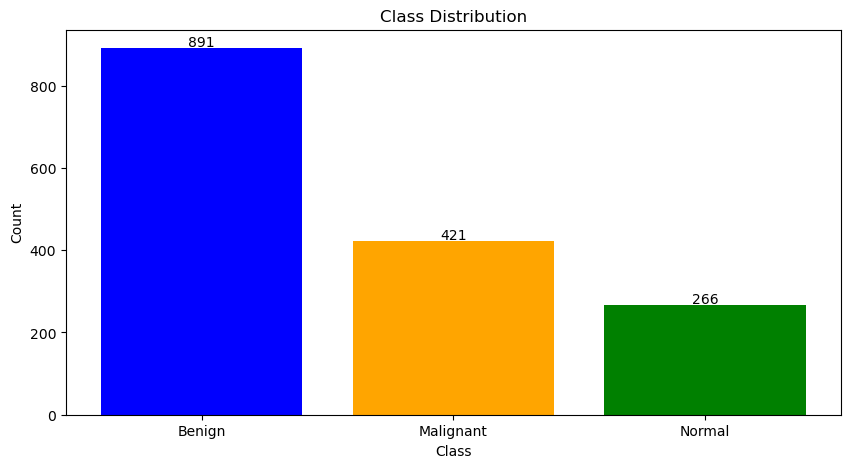

In [2]:
import tensorflow as tf
import numpy as np
import pathlib
import os
import cv2
import matplotlib.pyplot as plt

class ReadDataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape

    def imagesPath(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath, folder)).glob('*{}.*'.format(name)))
        return images

    def readImages(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels=channels)
            image = tf.image.resize(image, self.imageShape)
            image /= 255.0
            listImages.append(image)
        return listImages

    def allDataset(self, label):
        images = self.readImages(self.imagesPath(label, name=''), channels=3)
        masks = np.array(self.readImages(self.imagesPath(label, name='mask'), channels=1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks

    def finalDataset(self, labels):
        images_benign, masks_benign = self.allDataset(labels[0])
        images_malignant, masks_malignant = self.allDataset(labels[1])
        images_normal, masks_normal = self.allDataset(labels[2])
        images = np.vstack([images_benign, images_malignant, images_normal])
        masks = np.vstack([masks_benign, masks_malignant, masks_normal])
        labels = np.hstack([
            np.ones(shape=(len(images_benign),)) * 0,
            np.ones(shape=(len(images_malignant),)) * 1,
            np.ones(shape=(len(images_normal),)) * 2
        ])
        return images, masks, labels

    def dataAugmentation(self, images, masks, labels):
        images_update = []
        masks_update = []
        labels_update = []
        for image, mask, label in zip(images, masks, labels):
            for aug in range(5):
                image_up = image
                mask_up = mask
                if aug == 0:
                    image_up = image
                    mask_up = mask
                elif aug == 1:
                    image_up = tf.image.adjust_contrast(image_up, contrast_factor=2)
                elif aug == 2:
                    image_up = tf.image.adjust_brightness(image_up, delta=0.3)
                elif aug == 3:
                    image_up = tf.image.flip_left_right(image_up)
                    mask_up = tf.image.flip_left_right(mask_up)
                else:
                    image_up = cv2.GaussianBlur(image_up.numpy(), (5, 5), 0)
                images_update.append(image_up)
                masks_update.append(mask_up)
                labels_update.append(label)
        return np.array(images_update), np.array(masks_update), np.array(labels_update)

# Define the dataset path and labels
dataset_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
sub_dirs = ['benign', 'malignant', 'normal']

# Create an instance of the ReadDataset class
dataset = ReadDataset(datasetpath=dataset_dir, imageShape=(256, 256))

# Load and preprocess the dataset
images, masks, labels = dataset.finalDataset(sub_dirs)

# Plotting class distribution
def plot_class_distribution(labels, class_names):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))

    # Plot the distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts, color=['blue', 'orange', 'green'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center')
    plt.show()

# Define class names based on your dataset structure
class_names = ['Benign', 'Malignant', 'Normal']

# Plot the class distribution
plot_class_distribution(labels, class_names)


In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models
import pathlib
import os
import cv2
import string
from keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import pandas as pd

class readDataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape

    def imagesPath(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath, folder)).glob('*{}.*'.format(name)))
        return images

    def readImages(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels=channels)
            image = tf.image.resize(image, self.imageShape)
            image /= 255
            listImages.append(image)
        return listImages

    def allDataset(self, label):
        images = self.readImages(self.imagesPath(label, name=')'), channels=3)
        masks = np.array(self.readImages(self.imagesPath(label, name='mask'), channels=1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks

    def finalDataset(self, labels):
        images_benign, masks_benign = self.allDataset(labels[0])
        images_malignant, masks_malignant = self.allDataset(labels[1])
        images_normal, masks_normal = self.allDataset(labels[2])
        images = np.vstack([images_benign, images_malignant, images_normal])
        masks = np.vstack([masks_benign, masks_malignant, masks_normal])
        labels = np.hstack([np.ones(shape=(len(images_benign),))*0,
                            np.ones(shape=(len(images_malignant),))*1,
                            np.ones(shape=(len(images_normal),))*2])
        return images, masks, labels

    def dataAugmentation(self, images, masks, labels):
        imagesupdate = []
        masksupdate = []
        labelsupdate = []
        for image, mask, label in zip(images, masks, labels):
            for aug in range(5):
                imageup = image
                maskup = mask
                if aug == 0:
                    imageup = image
                    maskup = mask
                elif aug == 1:
                    imageup = tf.image.adjust_contrast(imageup, contrast_factor=2)
                elif aug == 2:
                    imageup = tf.image.adjust_brightness(imageup, delta=0.3)
                elif aug == 3:
                    imageup = tf.image.flip_left_right(imageup)
                    maskup = tf.image.flip_left_right(maskup)
                else:
                    imageup = cv2.GaussianBlur(imageup, (5, 5), 0)
                imagesupdate.append(imageup)
                masksupdate.append(maskup)
                labelsupdate.append(label)
        return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)

# Define the dataset path and labels
dataset_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
sub_dirs = ['benign', 'malignant', 'normal']
datasetObject = readDataset(dataset_dir, (128, 128))
images, masks, labels = datasetObject.finalDataset(sub_dirs)
print(images.shape, masks.shape, labels.shape)

images, masks, labels = datasetObject.dataAugmentation(images, masks, labels)
print(images.shape, masks.shape, labels.shape)
print(np.unique(labels, return_counts=True))
print(np.unique(masks, return_counts=True))
print(np.min(images), np.max(images))


(780, 128, 128, 3) (780, 128, 128, 1) (780,)
(3900, 128, 128, 3) (3900, 128, 128, 1) (3900,)
(array([0., 1., 2.]), array([2185, 1050,  665]))
(array([0, 1], dtype=int32), array([58967165,  4930435]))
-0.6637133 1.8423392


In [5]:
# Shuffle the dataset
randomIndexs = np.random.permutation(len(images))
images = images[randomIndexs]
masks = masks[randomIndexs]
labels = labels[randomIndexs]

# Split the dataset
valid = int(len(images) * 0.15)
trainDataset = [images[:images.shape[0] - valid],
                masks[:images.shape[0] - valid],
                labels[:images.shape[0] - valid]]
validDataset = [images[images.shape[0] - valid:],
                masks[images.shape[0] - valid:],
                labels[images.shape[0] - valid:]]

# Print the shapes of the training and validation sets
print(trainDataset[0].shape, trainDataset[1].shape, trainDataset[2].shape)
print(validDataset[0].shape, validDataset[1].shape, validDataset[2].shape)


(3315, 128, 128, 3) (3315, 128, 128, 1) (3315,)
(585, 128, 128, 3) (585, 128, 128, 1) (585,)


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
trainImages_flat = trainDataset[0].reshape(-1, trainDataset[0].shape[-1])
scaler.fit(trainImages_flat)
trainImages = scaler.transform(trainImages_flat).reshape(trainDataset[0].shape)
validImages_flat = validDataset[0].reshape(-1, validDataset[0].shape[-1])
validImages = scaler.transform(validImages_flat).reshape(validDataset[0].shape)

trainDataset[0] = trainImages
validDataset[0] = validImages

print(trainDataset[0].shape, validDataset[0].shape)


(3315, 128, 128, 3) (585, 128, 128, 3)


In [7]:
def convolution(inputs, padding, strides, filter, kernel_size):
    x = inputs
    y = layers.Conv2D(filter, kernel_size=1, padding=padding, strides=strides, kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = layers.Conv2D(filter, kernel_size=kernel_size, padding=padding, strides=strides, kernel_regularizer=tf.keras.regularizers.L2(0.001))(y)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter, kernel_size=kernel_size, padding=padding, strides=strides, kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, y])
    x = layers.Activation('relu')(x)
    return x

def encoder(inputs, filter, pool_size=(2, 2)):
    correlation = convolution(inputs, padding='same', strides=1, filter=filter, kernel_size=5)
    downsample = layers.AveragePooling2D(pool_size=pool_size)(correlation)
    return correlation, downsample

def decoder(inputs, skip_connection, filter):
    upsample = layers.Conv2DTranspose(filter, 5, padding='same', strides=2, kernel_regularizer=tf.keras.regularizers.L2(0.001))(inputs)
    upsample = layers.Activation('relu')(upsample)
    upsample = layers.BatchNormalization()(upsample)
    connection = layers.average([upsample, skip_connection])
    correlation = convolution(connection, padding='same', strides=1, filter=filter, kernel_size=5)
    return correlation

input = layers.Input(shape=(128, 128, 3))
filter = 16
corr1, downsample1 = encoder(input, filter)
corr2, downsample2 = encoder(downsample1, filter * 2)
corr3, downsample3 = encoder(downsample2, filter * 4)
corr4, downsample4 = encoder(downsample3, filter * 8)
downsample4 = convolution(downsample4, padding='same', strides=1, filter=filter * 8, kernel_size=5)

features_vector_1 = layers.GlobalAveragePooling2D()(downsample4)
features_vector_2 = layers.Flatten()(downsample4)
features_vector_2 = layers.Dropout(0.7)(features_vector_2)
features_vector_1 = layers.Dropout(0.5)(features_vector_1)

encoder_x = layers.Dense(64, name='latent_space', kernel_regularizer=tf.keras.regularizers.L2(0.001))(features_vector_1)
x = layers.Dense(downsample4.shape[1] * downsample4.shape[2] * downsample4.shape[3], kernel_regularizer=tf.keras.regularizers.L2(0.001))(encoder_x)
x = layers.Reshape((downsample4.shape[1], downsample4.shape[2], downsample4.shape[3]), name='reshape')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

decoder_corr1 = decoder(x, corr4, filter * 8)
decoder_corr2 = decoder(decoder_corr1, corr3, filter * 4)
decoder_corr3 = decoder(decoder_corr2, corr2, filter * 2)
decoder_corr4 = decoder(decoder_corr3, corr1, filter)

output = layers.Conv2DTranspose(1, 5, padding='same', strides=1)(decoder_corr4)
output = layers.Activation('sigmoid', name='UNET')(output)

labelOutput = layers.Dense(32, activation='relu')(features_vector_2)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(16, activation='relu')(labelOutput)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(1, name='label')(labelOutput)

m = models.Model(inputs=input, outputs=[output, labelOutput])
m.compile(loss=[tf.keras.losses.BinaryFocalCrossentropy(), 'mae'],
          optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
          metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
m.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         64        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         6416      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [9]:
m.compile(
    loss=[tf.keras.losses.BinaryFocalCrossentropy(), 'mae'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics={
        'UNET': ['accuracy', Precision(name='precision'), Recall(name='recall')],
        'label': ['mae']
    }
)
m.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         64        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         6416      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [ ]:
history = m.fit(
    trainDataset[0], 
    [trainDataset[1], trainDataset[2]], 
    epochs=600,
    validation_data=(validDataset[0], [validDataset[1], validDataset[2]]),
    batch_size=16, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=12, monitor='val_loss', mode='min', restore_best_weights=True),
    ]
)


Epoch 1/600


2024-07-11 13:52:26.015433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-11 13:52:29.124864: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-11 13:52:46.207093: I external/local_xla/xla/service/service.cc:168] XLA service 0x5635e9f36d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-11 13:52:46.207123: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-11 13:52:46.306444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720705966.453361    8536 device_compiler.h:186] Compiled cluster using XLA!  This line is l

208/208 [==============================] - 72s 138ms/step - loss: 4.0253 - UNET_loss: 0.0999 - label_loss: 1.7192 - UNET_accuracy: 0.8786 - UNET_precision: 0.0870 - UNET_recall: 0.0614 - label_mae: 1.7192 - val_loss: 2.9949 - val_UNET_loss: 0.0826 - val_label_loss: 0.7345 - val_UNET_accuracy: 0.9196 - val_UNET_precision: 4.3924e-04 - val_UNET_recall: 3.9280e-06 - val_label_mae: 0.7345
Epoch 2/600
208/208 [==============================] - 20s 97ms/step - loss: 3.9032 - UNET_loss: 0.0652 - label_loss: 1.6914 - UNET_accuracy: 0.9168 - UNET_precision: 0.2797 - UNET_recall: 0.0535 - label_mae: 1.6914 - val_loss: 2.8663 - val_UNET_loss: 0.0718 - val_label_loss: 0.6796 - val_UNET_accuracy: 0.9190 - val_UNET_precision: 0.2487 - val_UNET_recall: 0.0079 - val_label_mae: 0.6796
Epoch 3/600
208/208 [==============================] - 20s 95ms/step - loss: 3.8437 - UNET_loss: 0.0566 - label_loss: 1.7016 - UNET_accuracy: 0.9244 - UNET_precision: 0.5237 - UNET_recall: 0.1665 - label_mae: 1.7016 - val

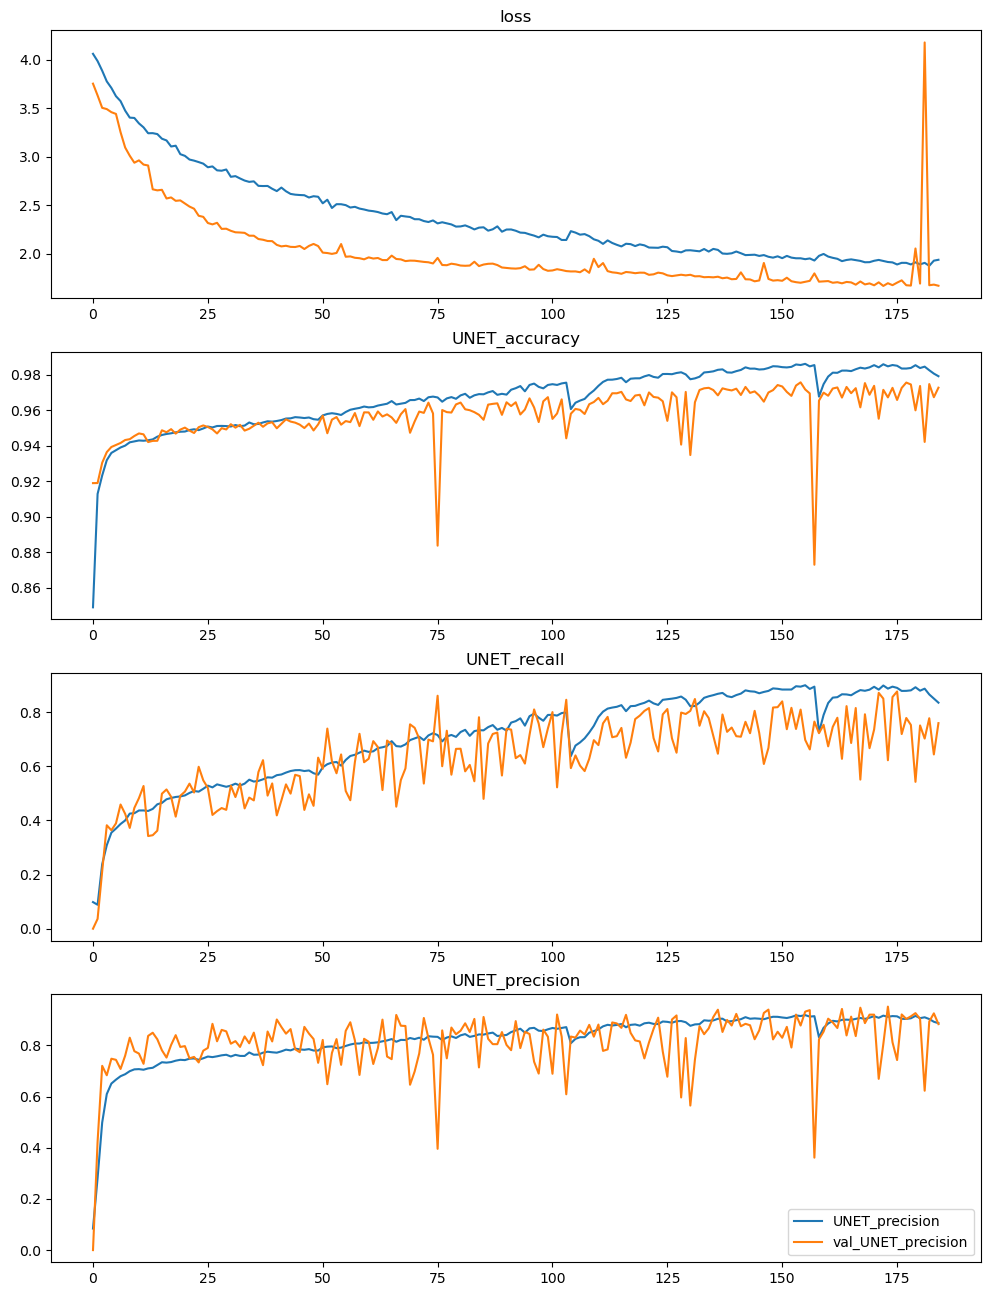

In [11]:
metrics = ['loss', 'UNET_accuracy', 'UNET_recall', 'UNET_precision']
plt.figure(figsize=(12, 16))
for i in range(4):
    plt.subplot(4, 1, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label='{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label='val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
plt.legend()


In [10]:
import os
import tensorflow as tf

# Define the checkpoint directory
checkpoint_dir = './checkpoints'  # Change to your desired directory
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}')

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=12, 
    monitor='val_loss', 
    mode='min', 
    restore_best_weights=True
)

# Training the model
history = m.fit(
    trainDataset[0], 
    [trainDataset[1], trainDataset[2]], 
    epochs=600,
    validation_data=(validDataset[0], [validDataset[1], validDataset[2]]),
    batch_size=16, 
    callbacks=[early_stopping_callback, checkpoint_callback]
)


Epoch 1/600


2024-07-11 15:56:34.969740: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-11 15:56:38.828777: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-11 15:56:58.630704: I external/local_xla/xla/service/service.cc:168] XLA service 0x55d6ea04c7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-11 15:56:58.630765: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-11 15:56:58.795311: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720713418.953702   30168 device_compiler.h:186] Compiled cluster using XLA!  This line is l

208/208 [==============================] - 75s 134ms/step - loss: 4.0590 - UNET_loss: 0.1121 - label_loss: 1.7434 - UNET_accuracy: 0.8489 - UNET_precision: 0.0842 - UNET_recall: 0.0983 - label_mae: 1.7434 - val_loss: 3.7515 - val_UNET_loss: 0.0902 - val_label_loss: 1.4872 - val_UNET_accuracy: 0.9189 - val_UNET_precision: 0.0000e+00 - val_UNET_recall: 0.0000e+00 - val_label_mae: 1.4872
Epoch 2/600
208/208 [==============================] - 20s 98ms/step - loss: 3.9840 - UNET_loss: 0.0737 - label_loss: 1.7686 - UNET_accuracy: 0.9128 - UNET_precision: 0.2816 - UNET_recall: 0.0885 - label_mae: 1.7686 - val_loss: 3.6302 - val_UNET_loss: 0.0650 - val_label_loss: 1.4568 - val_UNET_accuracy: 0.9190 - val_UNET_precision: 0.4240 - val_UNET_recall: 0.0363 - val_label_mae: 1.4568
Epoch 3/600
208/208 [==============================] - 20s 96ms/step - loss: 3.8851 - UNET_loss: 0.0589 - label_loss: 1.7483 - UNET_accuracy: 0.9232 - UNET_precision: 0.4982 - UNET_recall: 0.2381 - label_mae: 1.7483 - val

In [22]:
m.save('breast_cancer_segmentation.h5')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import os
import tensorflow as tf

# Define the checkpoint directory
checkpoint_dir = './checkpoints'  # Change to your desired directory
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}')

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=12, 
    monitor='val_loss', 
    mode='min', 
    restore_best_weights=True
)

# Assuming you saved the entire model as an HDF5 file
model_path = 'breast_cancer_segmentation.h5'  # Update with your actual path

# Load the model
if os.path.exists(model_path):
    m = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
else:
    print(f"Model file not found at {model_path}. Training from scratch.")

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Assuming 'm' is your model that you've loaded and compiled

# Compile the model
m.compile(
    loss=[tf.keras.losses.BinaryFocalCrossentropy(), 'mae'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics={
        'UNET': ['accuracy', Precision(name='precision'), Recall(name='recall')],
        'label': ['mae']
    }
)

# Continue training
history = m.fit(
    trainDataset[0], 
    [trainDataset[1], trainDataset[2]], 
    epochs=600,  # Continue from epoch 185 to 600
    initial_epoch=185,  # Start from epoch 185
    validation_data=(validDataset[0], [validDataset[1], validDataset[2]]),
    batch_size=16, 
    callbacks=[early_stopping_callback, checkpoint_callback]
)

Loaded model from breast_cancer_segmentation.h5
Epoch 186/600


2024-07-11 18:21:26.954081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


208/208 [==============================] - 35s 101ms/step - loss: 1.8952 - UNET_loss: 0.0104 - label_loss: 0.8325 - UNET_accuracy: 0.9842 - UNET_precision: 0.9079 - UNET_recall: 0.8840 - label_mae: 0.8325 - val_loss: 1.6809 - val_UNET_loss: 0.0264 - val_label_loss: 0.6028 - val_UNET_accuracy: 0.9718 - val_UNET_precision: 0.8755 - val_UNET_recall: 0.7549 - val_label_mae: 0.6028
Epoch 187/600
208/208 [==============================] - 20s 96ms/step - loss: 1.8978 - UNET_loss: 0.0093 - label_loss: 0.8374 - UNET_accuracy: 0.9857 - UNET_precision: 0.9143 - UNET_recall: 0.8976 - label_mae: 0.8374 - val_loss: 1.6701 - val_UNET_loss: 0.0223 - val_label_loss: 0.5974 - val_UNET_accuracy: 0.9760 - val_UNET_precision: 0.8888 - val_UNET_recall: 0.8004 - val_label_mae: 0.5974
Epoch 188/600
208/208 [==============================] - 20s 96ms/step - loss: 1.8980 - UNET_loss: 0.0096 - label_loss: 0.8387 - UNET_accuracy: 0.9854 - UNET_precision: 0.9141 - UNET_recall: 0.8933 - label_mae: 0.8387 - val_los

In [29]:
m.save('breast_cancer_segmentation2.h5')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
import os
import tensorflow as tf

# Define the checkpoint directory
checkpoint_dir = './checkpoints'  # Change to your desired directory
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}')

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=12, 
    monitor='val_loss', 
    mode='min', 
    restore_best_weights=True
)

# Assuming you saved the entire model as an HDF5 file
model_path = 'breast_cancer_segmentation2.h5'  # Update with your actual path

# Load the model
if os.path.exists(model_path):
    m = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
else:
    print(f"Model file not found at {model_path}. Training from scratch.")

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Assuming 'm' is your model that you've loaded and compiled

# Compile the model
m.compile(
    loss=[tf.keras.losses.BinaryFocalCrossentropy(), 'mae'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics={
        'UNET': ['accuracy', Precision(name='precision'), Recall(name='recall')],
        'label': ['mae']
    }
)

# Continue training
history = m.fit(
    trainDataset[0], 
    [trainDataset[1], trainDataset[2]], 
    epochs=400,  # Continue from epoch 238 to 600
    initial_epoch=238,  # Start from epoch 238
    validation_data=(validDataset[0], [validDataset[1], validDataset[2]]),
    batch_size=16, 
    callbacks=[early_stopping_callback, checkpoint_callback]
)

Loaded model from breast_cancer_segmentation2.h5
Epoch 239/400


2024-07-11 19:31:11.122063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


208/208 [==============================] - 36s 101ms/step - loss: 1.7854 - UNET_loss: 0.0083 - label_loss: 0.7743 - UNET_accuracy: 0.9871 - UNET_precision: 0.9228 - UNET_recall: 0.9071 - label_mae: 0.7743 - val_loss: 1.6081 - val_UNET_loss: 0.0214 - val_label_loss: 0.5848 - val_UNET_accuracy: 0.9773 - val_UNET_precision: 0.8898 - val_UNET_recall: 0.8174 - val_label_mae: 0.5848
Epoch 240/400
208/208 [==============================] - 20s 96ms/step - loss: 1.8031 - UNET_loss: 0.0089 - label_loss: 0.7932 - UNET_accuracy: 0.9865 - UNET_precision: 0.9181 - UNET_recall: 0.9043 - label_mae: 0.7932 - val_loss: 1.6098 - val_UNET_loss: 0.0196 - val_label_loss: 0.5899 - val_UNET_accuracy: 0.9784 - val_UNET_precision: 0.9121 - val_UNET_recall: 0.8074 - val_label_mae: 0.5899
Epoch 241/400
208/208 [==============================] - 21s 99ms/step - loss: 1.8242 - UNET_loss: 0.0080 - label_loss: 0.8167 - UNET_accuracy: 0.9875 - UNET_precision: 0.9245 - UNET_recall: 0.9115 - label_mae: 0.8167 - val_los

In [35]:
m.save('breast_cancer_segmentation3.h5')

In [39]:
import os
import tensorflow as tf

# Define the checkpoint directory
checkpoint_dir = './checkpoints'  # Change to your desired directory
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}')

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=12, 
    monitor='val_loss', 
    mode='min', 
    restore_best_weights=True
)

# Assuming you saved the entire model as an HDF5 file
model_path = 'breast_cancer_segmentation3.h5'  # Update with your actual path

# Load the model
if os.path.exists(model_path):
    m = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
else:
    print(f"Model file not found at {model_path}. Training from scratch.")

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Assuming 'm' is your model that you've loaded and compiled

# Compile the model
m.compile(
    loss=[tf.keras.losses.BinaryFocalCrossentropy(), 'mae'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics={
        'UNET': ['accuracy', Precision(name='precision'), Recall(name='recall')],
        'label': ['mae']
    }
)

# Continue training
history = m.fit(
    trainDataset[0], 
    [trainDataset[1], trainDataset[2]], 
    epochs=450,  # Continue from epoch 238 to 600
    initial_epoch=314,  # Start from epoch 238
    validation_data=(validDataset[0], [validDataset[1], validDataset[2]]),
    batch_size=16, 
    callbacks=[early_stopping_callback, checkpoint_callback]
)

Loaded model from breast_cancer_segmentation3.h5
Epoch 315/450


2024-07-11 20:12:09.885745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


208/208 [==============================] - 35s 101ms/step - loss: 1.6262 - UNET_loss: 0.0060 - label_loss: 0.6908 - UNET_accuracy: 0.9906 - UNET_precision: 0.9416 - UNET_recall: 0.9360 - label_mae: 0.6908 - val_loss: 1.5412 - val_UNET_loss: 0.0206 - val_label_loss: 0.5922 - val_UNET_accuracy: 0.9797 - val_UNET_precision: 0.9077 - val_UNET_recall: 0.8309 - val_label_mae: 0.5922
Epoch 316/450
208/208 [==============================] - 20s 96ms/step - loss: 1.6326 - UNET_loss: 0.0055 - label_loss: 0.6994 - UNET_accuracy: 0.9913 - UNET_precision: 0.9462 - UNET_recall: 0.9396 - label_mae: 0.6994 - val_loss: 1.4844 - val_UNET_loss: 0.0219 - val_label_loss: 0.5353 - val_UNET_accuracy: 0.9812 - val_UNET_precision: 0.9255 - val_UNET_recall: 0.8319 - val_label_mae: 0.5353
Epoch 317/450
208/208 [==============================] - 20s 96ms/step - loss: 1.6431 - UNET_loss: 0.0073 - label_loss: 0.7092 - UNET_accuracy: 0.9893 - UNET_precision: 0.9340 - UNET_recall: 0.9262 - label_mae: 0.7092 - val_los

In [43]:
import os
import tensorflow as tf

# Define the checkpoint directory
checkpoint_dir = './checkpoints'  # Change to your desired directory
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}')

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a ModelCheckpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Define EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=12, 
    monitor='val_loss', 
    mode='min', 
    restore_best_weights=True
)

# Assuming you saved the entire model as an HDF5 file
model_path = 'breast_cancer_segmentation3.h5'  # Update with your actual path

# Load the model
if os.path.exists(model_path):
    m = tf.keras.models.load_model(model_path)
    print(f"Loaded model from {model_path}")
else:
    print(f"Model file not found at {model_path}. Training from scratch.")

import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Assuming 'm' is your model that you've loaded and compiled

# Compile the model
m.compile(
    loss=[tf.keras.losses.BinaryFocalCrossentropy(), 'mae'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics={
        'UNET': ['accuracy', Precision(name='precision'), Recall(name='recall')],
        'label': ['mae']
    }
)

# Continue training
history = m.fit(
    trainDataset[0], 
    [trainDataset[1], trainDataset[2]], 
    epochs=500,  # Continue from epoch 238 to 600
    initial_epoch=369,  # Start from epoch 238
    validation_data=(validDataset[0], [validDataset[1], validDataset[2]]),
    batch_size=16, 
    callbacks=[early_stopping_callback, checkpoint_callback]
)

Loaded model from breast_cancer_segmentation3.h5
Epoch 370/500


2024-07-11 20:37:16.451182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


208/208 [==============================] - 37s 105ms/step - loss: 1.6505 - UNET_loss: 0.0057 - label_loss: 0.7150 - UNET_accuracy: 0.9910 - UNET_precision: 0.9443 - UNET_recall: 0.9376 - label_mae: 0.7150 - val_loss: 1.5185 - val_UNET_loss: 0.0182 - val_label_loss: 0.5711 - val_UNET_accuracy: 0.9819 - val_UNET_precision: 0.9246 - val_UNET_recall: 0.8430 - val_label_mae: 0.5711
Epoch 371/500
208/208 [==============================] - 20s 97ms/step - loss: 1.6417 - UNET_loss: 0.0068 - label_loss: 0.7062 - UNET_accuracy: 0.9896 - UNET_precision: 0.9366 - UNET_recall: 0.9265 - label_mae: 0.7062 - val_loss: 1.5408 - val_UNET_loss: 0.0157 - val_label_loss: 0.5969 - val_UNET_accuracy: 0.9830 - val_UNET_precision: 0.8908 - val_UNET_recall: 0.8981 - val_label_mae: 0.5969
Epoch 372/500
208/208 [==============================] - 20s 97ms/step - loss: 1.6510 - UNET_loss: 0.0055 - label_loss: 0.7176 - UNET_accuracy: 0.9912 - UNET_precision: 0.9457 - UNET_recall: 0.9395 - label_mae: 0.7176 - val_los

In [44]:
masks_pred, _ = m.predict(validDataset[0])
masks_pred.shape, validDataset[1].shape
masks_pred = (masks_pred >= 0.5).astype('int32')
np.unique(masks_pred), np.unique(validDataset[1])


19/19 [==============================] - 1s 41ms/step


(array([0, 1], dtype=int32), array([0, 1], dtype=int32))

In [45]:
masks_pred = layers.Flatten()(masks_pred)
masks_pred  = np.reshape(masks_pred, -1)
masks_actual = layers.Flatten()(validDataset[1])
masks_actual  = np.reshape(masks_actual, -1)
masks_pred.shape, masks_actual.shape
print(classification_report(masks_actual, masks_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99   8817846
           1       0.91      0.91      0.91    766794

    accuracy                           0.99   9584640
   macro avg       0.95      0.95      0.95   9584640
weighted avg       0.99      0.99      0.99   9584640



In [46]:
tn, fp, fn, tp = confusion_matrix(masks_actual, masks_pred).ravel()
metrics = pd.DataFrame([accuracy_score(masks_actual, masks_pred)*100,
                        precision_score(masks_actual, masks_pred)*100,
                        recall_score(masks_actual, masks_pred)*100,
                        f1_score(masks_actual, masks_pred)*100,
                        (tn / (tn+fp))*100,
                        (2*tp/(2*tp + fp + fn))*100,
                        (tp/(tp + fn))*100],
                       index=['Accuracy Score', 'Precision Score',
                              'Recall Score', 'F1 Score', 'specificity',
                              'dice Score', 'sensitivity'],
                       columns=['Metrics For Validation Data'])
metrics.head(n=8)


Metrics For Validation Data
Accuracy Score                     98.575053
Precision Score                    91.214747
Recall Score                       90.948286
F1 Score                           91.081322
specificity                        99.238272
dice Score                         91.081322
sensitivity                        90.948286

In [47]:
m.save('breast_cancer_segmentationfinal.h5')

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
# Save the entire model
m.save('my_model.h5')

In [52]:
import pickle

# Save the history
with open('train_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


In [53]:
np.save('train_images.npy', trainDataset[0])
np.save('train_masks.npy', trainDataset[1])
np.save('train_labels.npy', trainDataset[2])
np.save('valid_images.npy', validDataset[0])
np.save('valid_masks.npy', validDataset[1])
np.save('valid_labels.npy', validDataset[2])


In [48]:
def segmentation(data):
    masks_pred, _ = m.predict(data)
    masks_pred = np.array(masks_pred)
    masks_pred = (masks_pred >= 0.5).astype('int32')
    return masks_pred

valid_masks = segmentation(validDataset[0])
valid_masks.shape


19/19 [==============================] - 1s 41ms/step


(585, 128, 128, 1)

In [49]:
def draw(images, masks, y_pred):
    plt.figure(figsize=(12, 50))
    index = -1
    n = np.random.randint(y_pred.shape[0])
    for i in range(120):
        plt.subplot(20, 6, (i + 1))
        if index == -1:
            plt.imshow(images[n])
            plt.title('Image')
            index = 0
        elif index == 0:
            plt.imshow(images[n])
            plt.imshow(masks[n], alpha=0.3, cmap='jet')
            plt.title('Original Mask')
            index = 1
        elif index == 1:
            plt.imshow(images[n])
            plt.imshow(np.reshape(y_pred[n], (128, 128)), alpha=0.3, cmap='jet')
            plt.title('Predict Mask')
            index = -1
            n = np.random.randint(y_pred.shape[0])
    plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


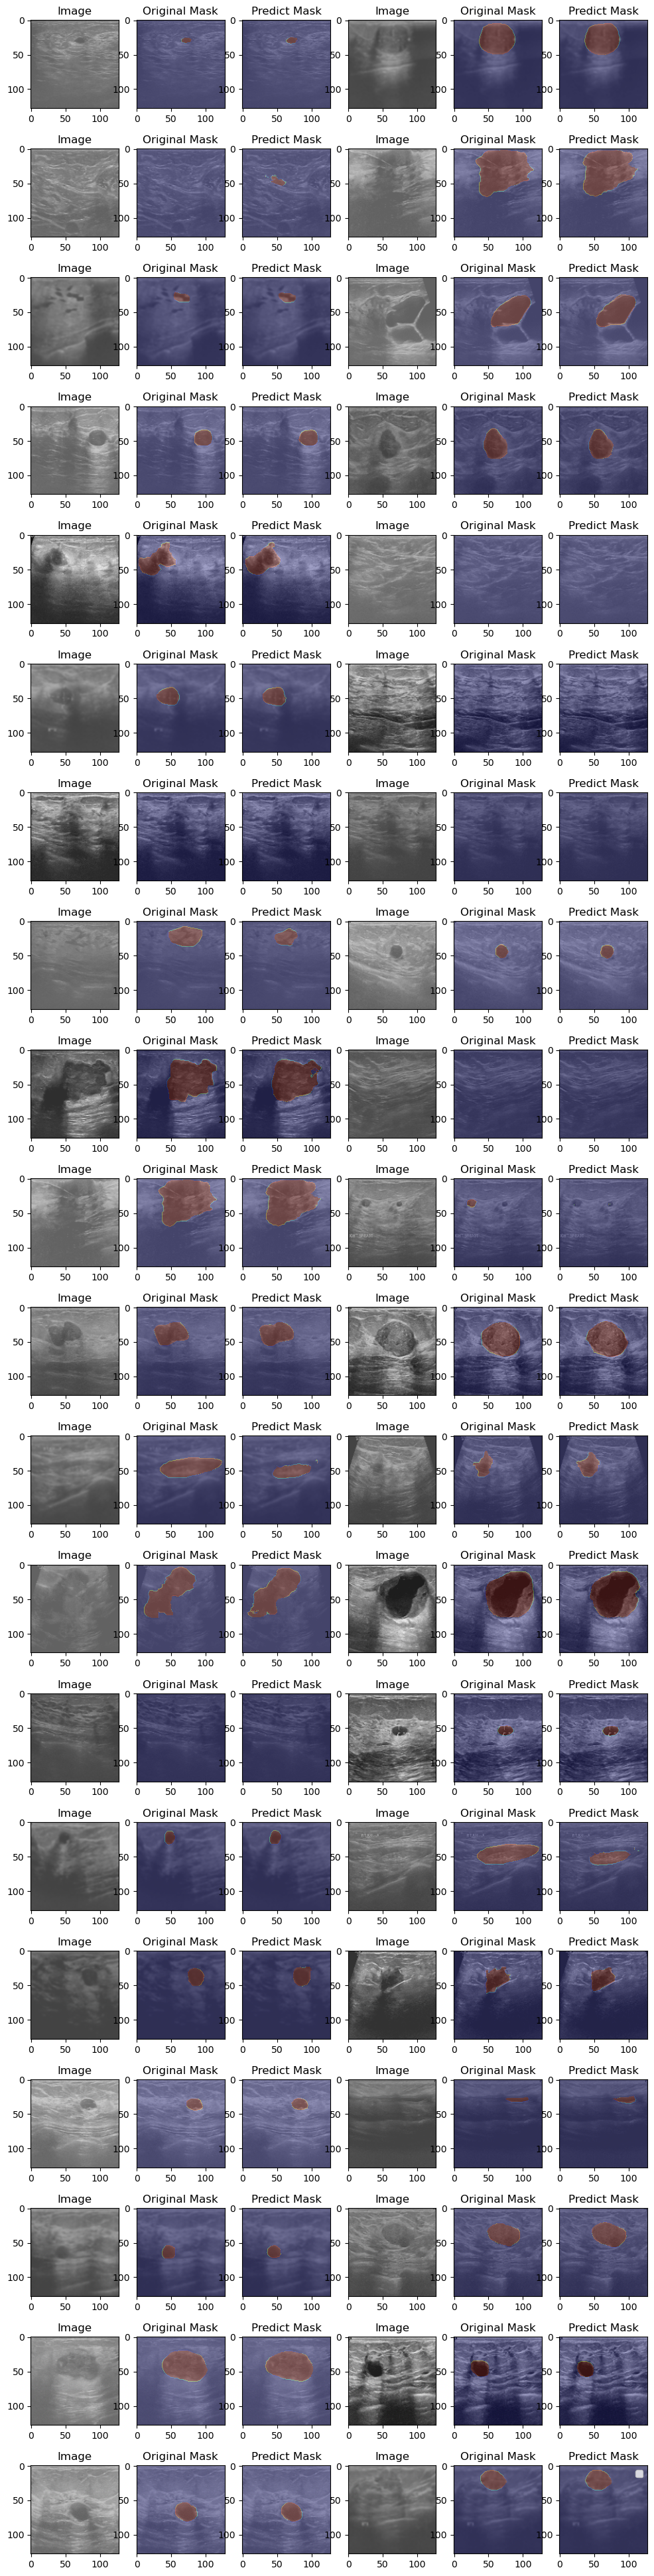

In [54]:
draw(validDataset[0], validDataset[1], valid_masks)

In [56]:
train_masks = segmentation(trainDataset[0])
train_masks.shape

104/104 [==============================] - 6s 57ms/step


(3315, 128, 128, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


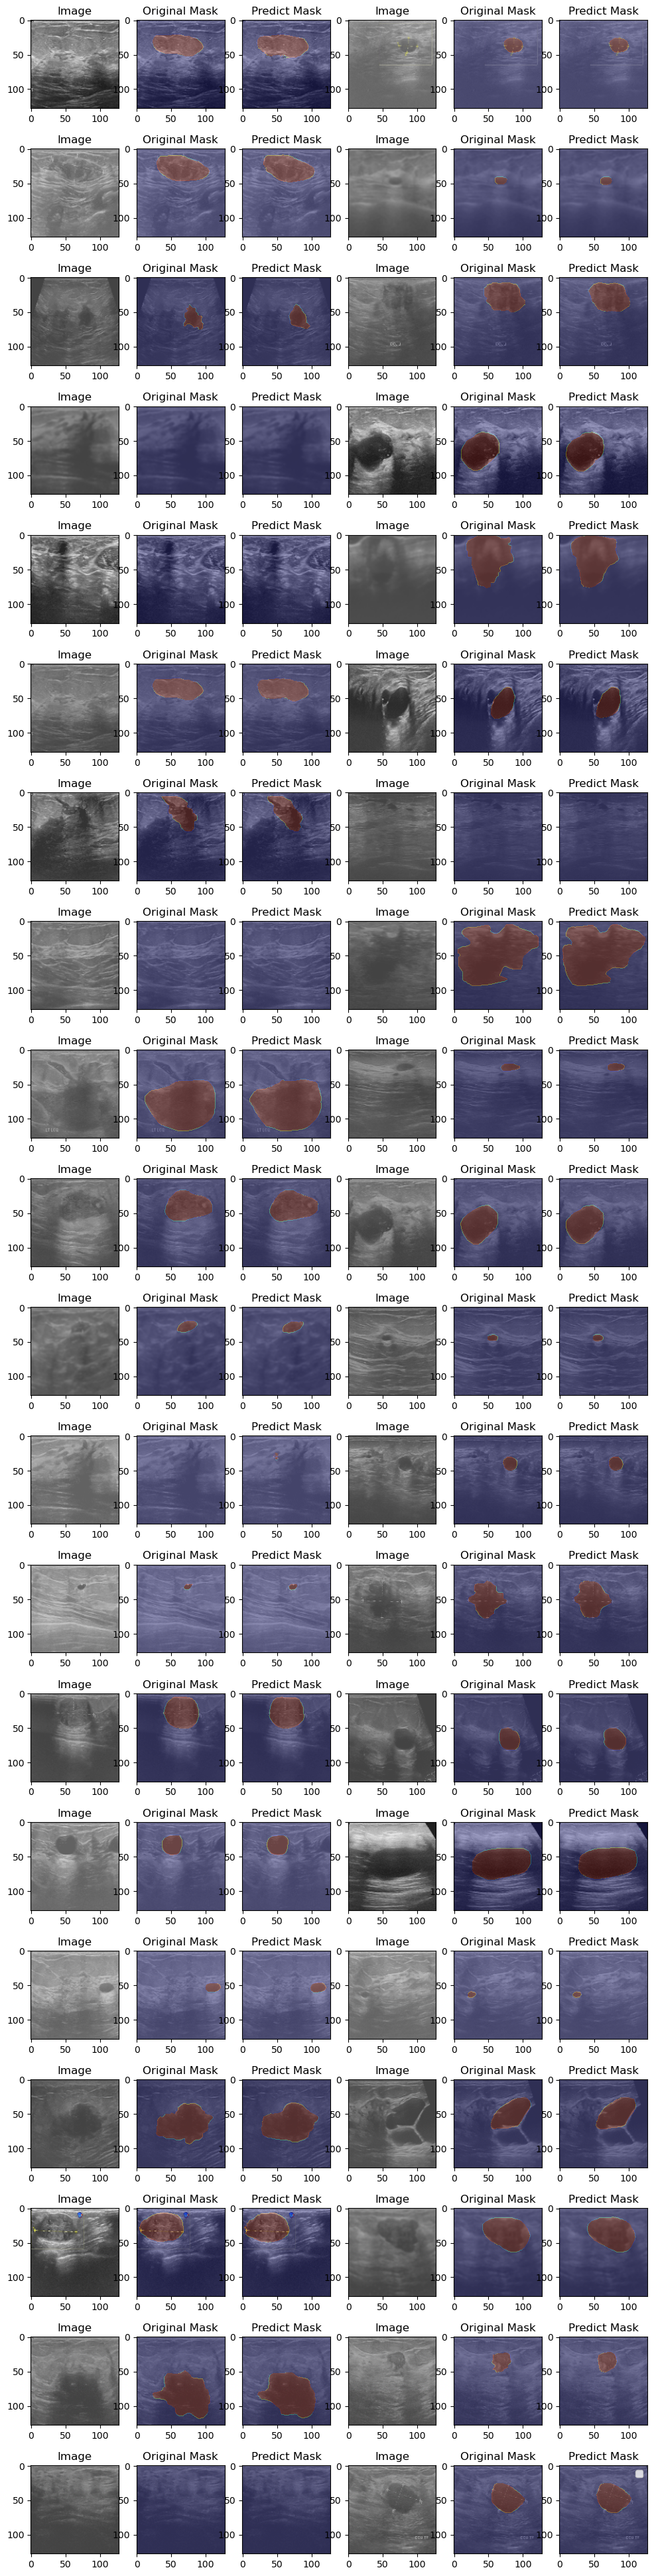

In [57]:
draw(trainDataset[0], trainDataset[1], train_masks)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


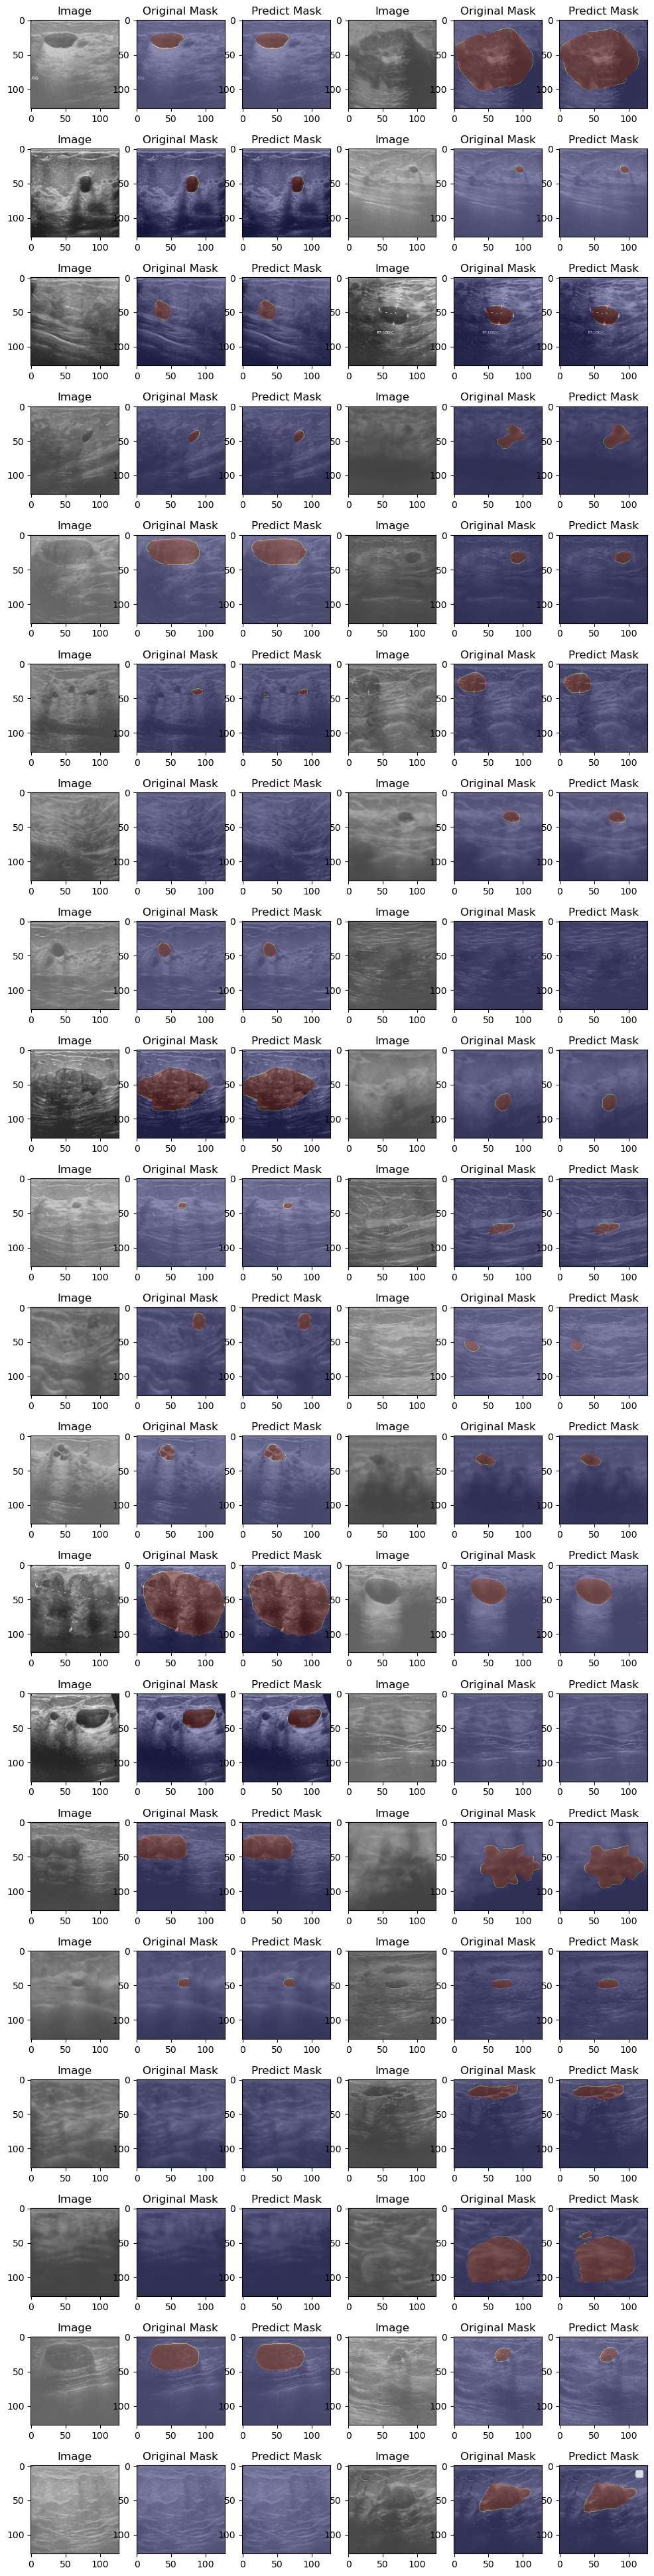

In [58]:
draw(trainDataset[0], trainDataset[1], train_masks)

In [59]:
m.save('breast_cancer_segmentation_f2.h5')